# Introduction

- Task: Multi-class Classification    
- Method: Linear Neural Network
- Library: PyTorch
- Dataset: CIFAR-10
    - https://www.cs.toronto.edu/~kriz/cifar.html
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10
    - The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    - Classes: {airplain, automobile, bird, cat, deer, dog, frog, horse, ship, truck}

# Set Environment

In [69]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [70]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/Linear')

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

torch.manual_seed(42)

Selected device: cuda


# Process Data

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10('/home/june/__github__/playground/data',
                                 download = True, train = True, transform = transform)

test_dataset = datasets.CIFAR10('/home/june/__github__/playground/data',
                                download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [73]:
test_dataset[5][0].shape

torch.Size([3, 32, 32])

In [74]:
batch_size = 512

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                          shuffle=True, num_workers = 0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                         shuffle = False, num_workers = 0)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [75]:
img, lbl = next(iter(trainloader))
img.shape, lbl.shape

(torch.Size([512, 3, 32, 32]), torch.Size([512]))

# Define Model

## Model Structure

In [76]:
class LinearClassifier(nn.Module):
    '''
    linear classifier for batch input
    '''
    def __init__(self, input_size, num_classes):
        '''
        construct single fully connected layer

        Args:
            input_size: int
            num_classes: int
        '''
        super().__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        '''
        forward pass through model
        flatten image, forward

        Args:
            x: torch.Tensor, (batch_size, channel, width, height)
        '''
        x = x.view((x.size(0), -1))
        x = self.fc(x)
        return x

In [77]:
# # nn.Linear를 사용하지 않고 구현
# class LinearClassifier(nn.Module):
#     '''
#     linear classifier for batch input
#     '''
#     def __init__(self, input_size, num_classes):
#         '''
#         construct single fully connected layer

#         Args:
#             input_size: int
#             num_classes: int
#         '''
#         super().__init__()
#         self.W = nn.Parameter(torch.randn(input_size + 1, num_classes))
#         self.b = nn.Parameter(torch.randn(num_classes))

#     def forward(self, x):
#         '''
#         forward pass through model

#         Args:
#             x(batched image): torch.Tensor, (batch_size, channel, width, height)

#         Returns:
#             x(logit): torch.Tensor, (batch_size, num_classes)
#         '''
#         x = x.view((x.size(0), -1))

#         x = torch.matmul(x, self.W) + self.b

#         return x

## Hyperparameter & Functions

In [78]:
input_size = 3*32*32
num_classes = 10

model = LinearClassifier(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

# Train

In [80]:
def train_model(model, criterion, optimizer, trainloader, num_epochs):
    print("-----Training Started------")
    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save(model, './model/Linear.pth')
        
    print("-----Training Completed-----")

In [81]:
num_epochs = 16

train_model(model, criterion, optimizer, trainloader, num_epochs)
writer.flush()
writer.close()

-----Training Started------


100%|██████████| 98/98 [00:05<00:00, 16.89it/s]


Epoch [1/16], Loss: 1.8447


100%|██████████| 98/98 [00:05<00:00, 16.83it/s]


Epoch [2/16], Loss: 1.7521


100%|██████████| 98/98 [00:05<00:00, 16.81it/s]


Epoch [3/16], Loss: 1.7241


100%|██████████| 98/98 [00:05<00:00, 16.72it/s]


Epoch [4/16], Loss: 1.7074


100%|██████████| 98/98 [00:05<00:00, 16.74it/s]


Epoch [5/16], Loss: 1.6968


100%|██████████| 98/98 [00:05<00:00, 16.78it/s]


Epoch [6/16], Loss: 1.6912


100%|██████████| 98/98 [00:05<00:00, 16.78it/s]


Epoch [7/16], Loss: 1.6803


100%|██████████| 98/98 [00:05<00:00, 16.80it/s]


Epoch [8/16], Loss: 1.6769


100%|██████████| 98/98 [00:05<00:00, 16.47it/s]


Epoch [9/16], Loss: 1.6703


100%|██████████| 98/98 [00:05<00:00, 16.75it/s]


Epoch [10/16], Loss: 1.6737


100%|██████████| 98/98 [00:05<00:00, 16.72it/s]


Epoch [11/16], Loss: 1.6699


100%|██████████| 98/98 [00:05<00:00, 16.68it/s]


Epoch [12/16], Loss: 1.6640


100%|██████████| 98/98 [00:05<00:00, 16.70it/s]


Epoch [13/16], Loss: 1.6593


100%|██████████| 98/98 [00:05<00:00, 16.79it/s]


Epoch [14/16], Loss: 1.6565


100%|██████████| 98/98 [00:05<00:00, 16.97it/s]


Epoch [15/16], Loss: 1.6548


100%|██████████| 98/98 [00:05<00:00, 16.97it/s]

Epoch [16/16], Loss: 1.6514
-----Training Completed-----


# Test

In [82]:
def test_model(model, testloader):
    
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")

In [89]:
test_model(model, testloader)

100%|██████████| 20/20 [00:01<00:00, 17.24it/s]

Accuracy on test set: 0.4040


# Inference

In [84]:
import random

def random_sample(dataset, n):
    '''
    random sample n images from dataset

    Args:
        dataset: torchvision.datasets.cifar.CIFAR10
        n: int

    Returns:
        sampled_images: torch.tensor, (n, channel, width, height)
        sampled_labels: torch.tensor, (n)
    '''
    indices = random.sample(range(len(dataset)), n)
    
    sampled_images = torch.stack([dataset[i][0] for i in indices])
    sampled_labels = torch.tensor([dataset[i][1] for i in indices])

    return sampled_images, sampled_labels

In [85]:
def inference(model, images):
    '''
    forward pass through model, select class

    Args:
        model: LinearClassifier
        images: torch.tensor, (n, channel, width, height)

    Returns:
        predicted_labels: torch.tensor, (n)
    '''
    model.eval()

    with torch.no_grad():

        images = images.to(device)
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        
    return predicted_labels

In [86]:
def visualize(sampled_images, sampled_labels, predicted_labels):
    '''
    visualize image, labels, prediction by matplotlib.pyplot

    Args:
        sampled_images: torch.tensor, (n, channel, width, height)
        sampled_labels: torch.tensor, (n)
        predicted_labels: torch.tensor, (n)
    '''
    n = sampled_images.size(0)
    
    plt.figure(figsize=(15, 3))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        image = sampled_images[i].permute(1, 2, 0)
        
        plt.imshow(image.numpy())
        plt.title(f"Label: {classes[sampled_labels[i].item()]}\nPred: {classes[predicted_labels[i].item()]}")
        plt.axis('off')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


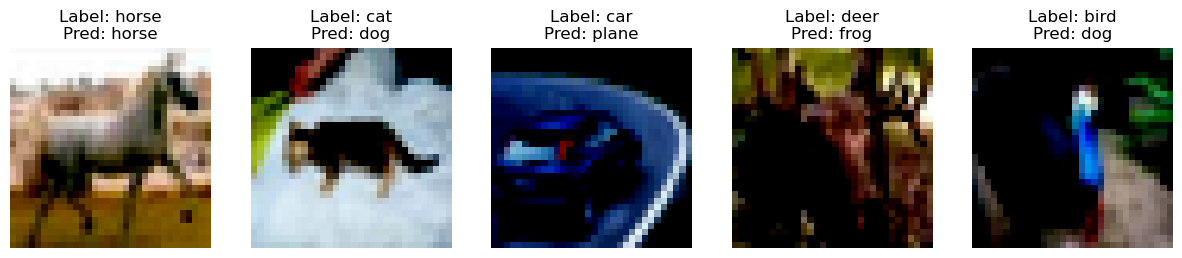

In [87]:
sampled_images, sampled_labels = random_sample(test_dataset, 5)
predicted_labels = inference(model, sampled_images)
visualize(sampled_images, sampled_labels, predicted_labels)

# Visualize Results

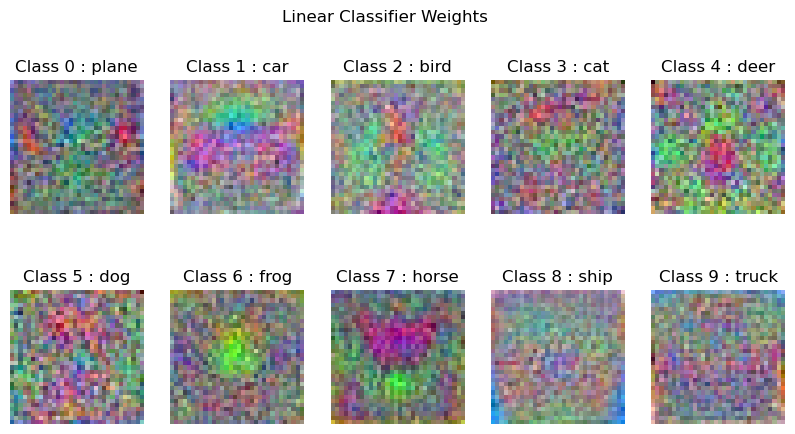

In [88]:
model = torch.load('./model/Linear.pth', weights_only=False)
weights = model.fc.weight.data.cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i+1)
    scaled_weights = (weights[i] - weights[i].min()) / (weights[i].max() - weights[i].min())
    scaled_weights = (scaled_weights * 255).astype(np.uint8)
    plt.imshow(scaled_weights.reshape(3, 32, 32).transpose(1,2,0))
    
    plt.title(f'Class {i} : {classes[i]}')
    plt.axis('off')
plt.suptitle('Linear Classifier Weights')
plt.show()